In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import matplotlib as mpl
import scipy.stats as st
from scipy.stats import (vonmises_line, norm, t, cauchy, lognorm, fisk, skewnorm, exponweib, genlogistic, logistic, laplace)
import hdbscan
import seaborn as sns
import colorcet as cc
import astropy.units as u
import xarray as xr
from sunpy.visualization.colormaps import cm
import zarr
import sunpy.map
from sunpy.coordinates import HeliographicCarrington
from astropy.coordinates import SkyCoord

from scipy import stats

import random

import glob
import os
from tqdm import tqdm

/d0/amunozj/.conda/envs/bard_tilt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define colors an colormaps

In [2]:
# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

### Read data, add date, Calibrate flux for MDI using 0.8 factor, and apply 3x10^21 Mx cuttoff

In [3]:
# Flux Cutoff in Maxwells
fCutoff = 3e21

KPVT = pd.read_csv('data/output/BARD_1976-1993_KPVT_tilts.csv')
KPVT = KPVT.loc[KPVT['BMRFlux']>=fCutoff,:]
KPVT['Date'] = pd.to_datetime(dict(year=KPVT.Year, month=KPVT.Month, day=KPVT.Day, hour=KPVT.Hour, minute=KPVT.Minute))
KPVT['Instrument'] = 'KPVT'

SPMG = pd.read_csv('data/output/BARD_1992-1999_SPMG_tilts.csv')
SPMG = SPMG.loc[SPMG['BMRFlux']>=fCutoff,:]
SPMG['Date'] = pd.to_datetime(dict(year=SPMG.Year, month=SPMG.Month, day=SPMG.Day, hour=SPMG.Hour, minute=SPMG.Minute))
SPMG['Instrument'] = 'SPMG'
SPMG['BMRLabel'] = SPMG['BMRLabel'] + np.max(KPVT['BMRLabel'])

MDIcalibration = 0.8
MDI = pd.read_csv('data/output/BARD_1996-2010_MDI_tilts.csv')
MDI.loc[:, ['PFlux', 'NFlux', 'BMRFlux']] *= MDIcalibration
MDI = MDI.loc[MDI['BMRFlux']>=fCutoff,:]
MDI['Date'] = pd.to_datetime(dict(year=MDI.Year, month=MDI.Month, day=MDI.Day, hour=MDI.Hour, minute=MDI.Minute))
MDI['Instrument'] = 'MDI'
MDI['BMRLabel'] = MDI['BMRLabel'] + np.max(SPMG['BMRLabel'])

HMI = pd.read_csv('data/output/BARD_2010-2016_HMI_tilts.csv')
HMI = HMI.loc[HMI['BMRFlux']>=fCutoff,:]
HMI['Date'] = pd.to_datetime(dict(year=HMI.Year, month=HMI.Month, day=HMI.Day, hour=HMI.Hour, minute=HMI.Minute))
HMI['Instrument'] = 'HMI'
HMI['BMRLabel'] = HMI['BMRLabel'] + np.max(MDI['BMRLabel'])


In [4]:
HMI

,ReferenceDay,Year,Month,Day,Hour,Minute,Second,BMRLabel,PFlux,PArea,...,HH_24n,AH_24n,HH_24s,AH_24s,Cycle24n,Cycle24s,Hale,AntiHale,Date,Instrument
1,486,2010,5,2,21,46,22.4,13425,5.720000e+21,2.400000e+19,...,True,False,False,False,True,False,True,False,2010-05-02 21:46:00,HMI
4,488,2010,5,4,21,46,22.6,13428,3.050000e+21,1.570000e+19,...,False,False,True,False,False,True,True,False,2010-05-04 21:46:00,HMI
5,490,2010,5,6,21,46,22.9,13429,4.240000e+21,1.410000e+19,...,True,False,False,False,True,False,True,False,2010-05-06 21:46:00,HMI
6,507,2010,5,23,21,46,24.7,13430,3.420000e+21,7.870000e+18,...,False,False,True,False,False,True,True,False,2010-05-23 21:46:00,HMI
7,512,2010,5,28,21,46,25.1,13431,2.150000e+21,8.790000e+18,...,True,False,False,False,True,False,True,False,2010-05-28 21:46:00,HMI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,2719,2016,6,12,21,46,46.7,16059,4.150000e+21,2.040000e+19,...,True,False,False,False,True,False,True,False,2016-06-12 21:46:00,HMI
1451,2724,2016,6,17,21,46,46.9,16063,3.950000e+21,1.390000e+19,...,False,False,True,False,False,True,True,False,2016-06-17 21:46:00,HMI
1453,2725,2016,6,18,21,46,47.0,16066,2.080000e+21,1.060000e+19,...,True,False,False,False,True,False,True,False,2016-06-18 21:46:00,HMI
1454,2727,2016,6,20,21,46,47.0,16068,1.150000e+22,2.030000e+19,...,False,False,True,False,False,True,True,False,2016-06-20 21:46:00,HMI


### Remove overlaps between missions

In [5]:
KPVT = KPVT.loc[KPVT['Date']<np.min(SPMG['Date']),:]
SPMG = SPMG.loc[SPMG['Date']<np.min(MDI['Date']),:]
MDI = MDI.loc[MDI['Date']<np.min(HMI['Date']),:]

### Concatenate all instruments

In [6]:
allMag = pd.concat([KPVT, SPMG, MDI, HMI], ignore_index=True).drop(labels=['ReferenceDay', 'Flux_cut'], axis=1).replace(np.nan, False).sort_values(by = ['Date']).reset_index(drop = True)
allMag.to_csv('data/output/BARD_1976-2016_Merge_tilts.csv', index=False)

allMag['pltSize'] = (np.sqrt(allMag['BMRFlux']/1e21))
allMag

/tmp/ipykernel_1409081/1695521115.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  allMag = pd.concat([KPVT, SPMG, MDI, HMI], ignore_index=True).drop(labels=['ReferenceDay', 'Flux_cut'], axis=1).replace(np.nan, False).sort_values(by = ['Date']).reset_index(drop = True)


,Year,Month,Day,Hour,Minute,Second,BMRLabel,PFlux,PArea,PLatitude,...,AH_23s,Cycle23n,Cycle23s,HH_24n,AH_24n,HH_24s,AH_24s,Cycle24n,Cycle24s,pltSize
0,1976,1,13,17,26,59.0,1,6.690000e+21,1.590000e+19,-9.9094,...,False,False,False,False,False,False,False,False,False,4.614109
1,1976,2,15,18,19,8.0,3,2.370000e+21,1.170000e+19,-11.1080,...,False,False,False,False,False,False,False,False,False,1.939072
2,1976,2,20,18,43,18.0,4,2.490000e+21,1.440000e+19,-2.6919,...,False,False,False,False,False,False,False,False,False,2.209072
3,1976,3,13,21,24,36.0,8,3.080000e+21,1.270000e+19,-33.7100,...,False,False,False,False,False,False,False,False,False,2.424871
4,1976,8,12,21,14,0.0,13,1.790000e+21,9.400000e+18,23.7860,...,False,False,False,False,False,False,False,False,False,1.769181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7565,2016,6,13,21,46,46.7,16058,3.250000e+21,7.780000e+18,8.1019,...,False,False,False,True,False,False,False,True,False,2.983287
7566,2016,6,17,21,46,46.9,16063,3.950000e+21,1.390000e+19,-8.5136,...,False,False,False,False,False,True,False,False,True,2.505993
7567,2016,6,18,21,46,47.0,16066,2.080000e+21,1.060000e+19,6.2451,...,False,False,False,True,False,False,False,True,False,2.017424
7568,2016,6,20,21,46,47.0,16068,1.150000e+22,2.030000e+19,-6.1588,...,False,False,False,False,False,True,False,False,True,3.506565


In [7]:
for k in allMag.BMRLabel:
    df_k = pd.DataFrame((allMag.BMRLabel==k))*1
    
allMag[allMag.BMRLabel==247].index[1]
#allMag.drop(135,axis=0)

138

In [8]:
for k in allMag.BMRLabel:
    df_k = (allMag.BMRLabel==k)*1
    suma = df_k.sum()#[0]
    if suma > 1:
        index_1 = allMag[allMag.BMRLabel==k].index[1]
        allMag = allMag.drop(index_1, axis=0)

In [9]:
df = pd.DataFrame(allMag.BMRLabel)
counter = 0
for k in allMag.BMRLabel:
    df_k = (allMag.BMRLabel==k)*1
    suma = df_k.sum()#[0]
    if suma > 1:
        counter +=1
        print('Problema en BMRLabel ', k)

In [10]:
allMag = allMag.reset_index()

### Plot data

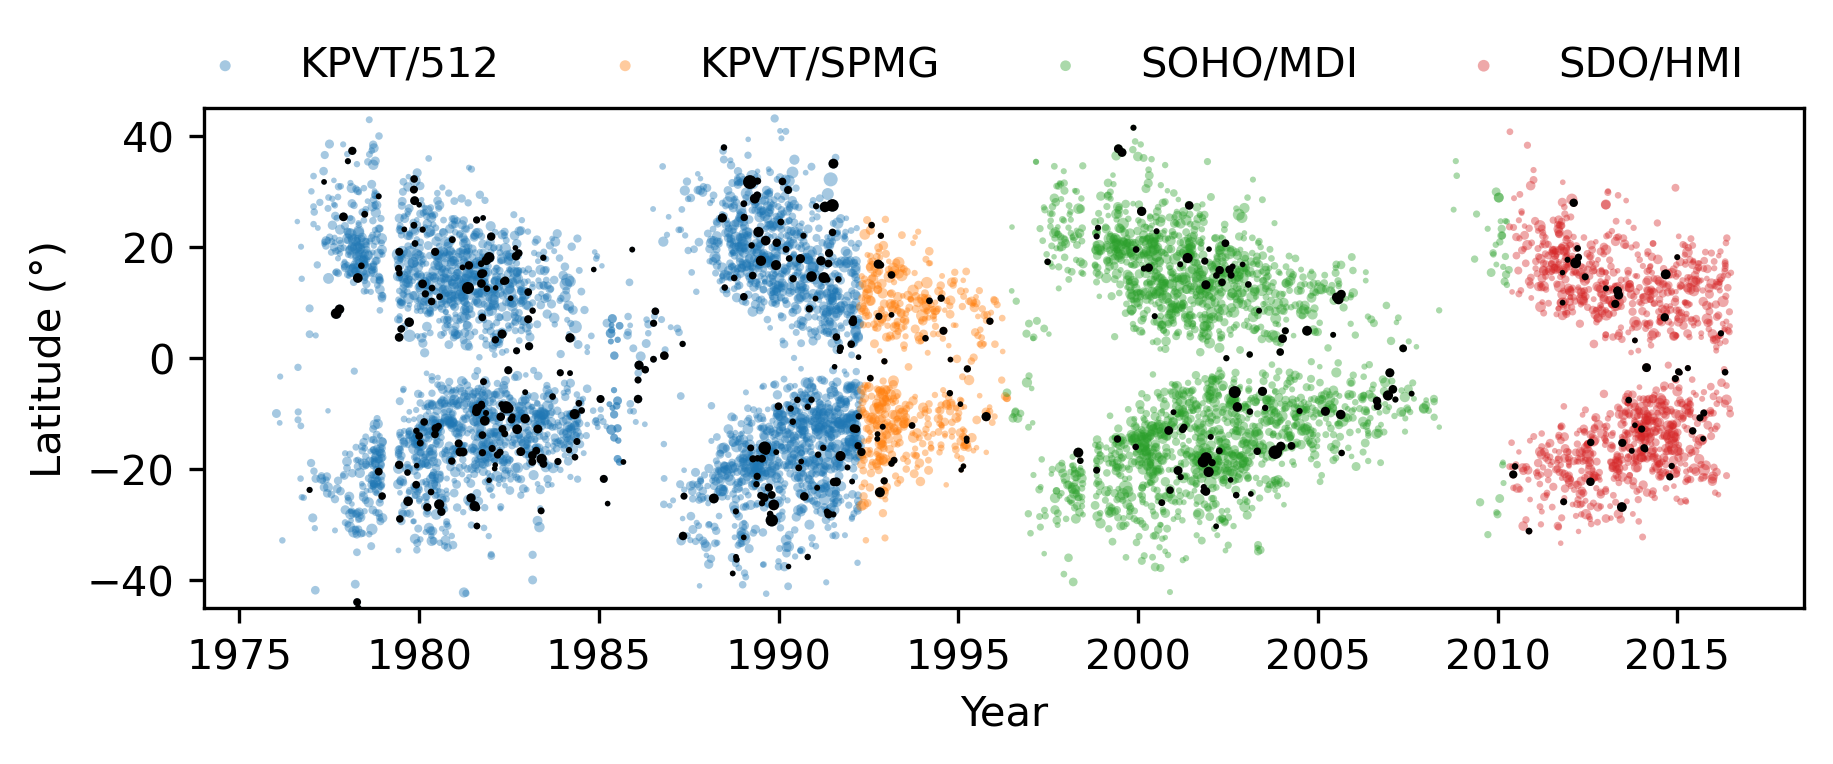

In [11]:
# Size definitions
dpi = 300
pxx = 1600  # Horizontal size of each panel
pxy = 500  # Vertical size of each panel

nph = 5     # Number of horizontal panels
npv = 6     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy])

size = (np.sqrt(KPVT['BMRFlux']/1e21))
ax1.scatter(KPVT['Date'], KPVT['BMRLatitude'], s=size, alpha=0.4, ec='None', label='KPVT/512')


size = (np.sqrt(SPMG['BMRFlux']/1e21))
ax1.scatter(SPMG['Date'], SPMG['BMRLatitude'], s=size, alpha=0.4, ec='None', label='KPVT/SPMG')


size = (np.sqrt(MDI['BMRFlux']/1e21))
ax1.scatter(MDI['Date'], MDI['BMRLatitude'], s=size, alpha=0.4, ec='None', label='SOHO/MDI')


size = (np.sqrt(HMI['BMRFlux']/1e21))
ax1.scatter(HMI['Date'], HMI['BMRLatitude'], s=size, alpha=0.4, ec='None', label='SDO/HMI')


size = (np.sqrt(allMag['BMRFlux']/1e21))
mask = allMag['AntiHale']
ax1.scatter(allMag.loc[mask,'Date'], allMag.loc[mask,'BMRLatitude'], s=size[mask], alpha=1,fc='k', ec='None')


ax1.set_ylim([-45, 45])
ax1.set_ylabel('Latitude (°)')
ax1.set_xlabel('Year')
ax1.legend(frameon=False, ncol=4, loc='upper center', bbox_to_anchor=(0.475, 1.2))



# BMR Dipole moment

In [ ]:
allMag['BMRColatitude'] = (90 - allMag.BMRLatitude) * np.pi/180
allMag['PColatitude'] = (90 - allMag.PLatitude) * np.pi/180
allMag['NColatitude'] = (90 - allMag.NLatitude) * np.pi/180

R_sun = 6.96 * 10e8 * 10e2  # cm
allMag['D_bmr'] = (3/(4*np.pi)) * allMag.BMRFlux * (np.cos(allMag.PColatitude) - np.cos(allMag.NColatitude)) / R_sun**2

In [ ]:
tbins = np.arange(-90, 90, 2)
x = np.linspace(-90, 90, 100)

# Size definitions
dpi = 400
pxx = 600  # Horizontal size of each panel
pxy = 500  # Vertical size of each panel

nph = 5     # Number of horizontal panels
npv = 6     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


# Combine hemispheres 


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

ax1 = fig.add_axes([ppadh, ppadv, 4*ppxx, ppxy])

size = (np.sqrt(allMag['BMRFlux']/1e21))


for cyc in np.arange(21,25):

    mask = np.logical_or(allMag[f'Cycle{str(cyc)}n'],allMag[f'Cycle{str(cyc)}s'])

    

    if cyc%2 == 0:

        maskp = np.logical_and(mask, allMag['D_bmr']>0)
        ax1.scatter(allMag.loc[maskp,'Date'], allMag.loc[maskp,'BMRLatitude'], s=size[maskp], alpha=0.4, ec='None', c='r')

        maskn = np.logical_and(mask, allMag['D_bmr']<0)
        ax1.scatter(allMag.loc[maskn,'Date'], allMag.loc[maskn,'BMRLatitude'], s=size[maskn], alpha=0.4, ec='None', c='b')

    else:

        maskn = np.logical_and(mask, allMag['D_bmr']<0)
        ax1.scatter(allMag.loc[maskn,'Date'], allMag.loc[maskn,'BMRLatitude'], s=size[maskn], alpha=0.4, ec='None', c='b')        

        maskp = np.logical_and(mask, allMag['D_bmr']>0)
        ax1.scatter(allMag.loc[maskp,'Date'], allMag.loc[maskp,'BMRLatitude'], s=size[maskp], alpha=0.4, ec='None', c='r')

    print(cyc, np.sum(allMag.loc[maskp, 'D_bmr']), np.sum(allMag.loc[maskn, 'D_bmr']))



ax1.set_ylim([-45, 45])
ax1.set_ylabel('Latitude (°)')
ax1.set_xlabel('Year')
# ax1.legend(frameon=False, ncol=5, loc='upper center', bbox_to_anchor=(0.475, 1.2))

### Remove spotless days

In [ ]:
allMag = allMag.loc[np.isfinite(allMag["BMRLatitude"]), :]

# Active longitudes

In [12]:
# reference day
# time_0 = '1970-01-01 00:00:00'

time_0 = pd.to_datetime(0)
ref_day = (allMag['Date'] - time_0)

for i in range(len(ref_day)):
    ref_day[i] = ref_day[i].days

allMag['ReferenceDay'] = ref_day
ref_day

/tmp/ipykernel_1409081/3177668154.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2203' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  ref_day[i] = ref_day[i].days


0        2203
1        2236
2        2241
3        2263
4        2415
        ...  
7538    16965
7539    16969
7540    16970
7541    16972
7542    16981
Name: Date, Length: 7543, dtype: object

In [13]:
# diferential rotation

def dif_rotation(lat):
    A = 14.113463 *u.deg / u.d             # degrees/days
    B = -1.6979719 *u.deg / u.d            # degrees/days
    C = -1.787 *u.deg / u.d            # degrees/days
    c_r = 14.182768 *u.deg / u.d      # degrees/days

    return(A + B * np.sin(lat)**2 + C * np.sin(lat)**4)

In [14]:
allMag["DRot"] = dif_rotation(allMag["BMRLatitude"])

## Tarea Oct/12/23

- Para una region, calcular la distancia a todas las demas usando la latitud y la longitud corregida OK
- Hacer la matriz de distancias OK
- revisar que sea simétrica OK
- se puede visualizar usando ax.pcolormesh

### brownie points
- probar el hdbscan con esa matriz

Ejemplo de visualización https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

Usar UMAP:  https://umap-learn.readthedocs.io/en/latest/
si no, t-SNE


In [15]:
# distancia para una región
# https://www.movable-type.co.uk/scripts/latlong.html

def reg_distance(all_mag, region):
    # https://www.movable-type.co.uk/scripts/latlong.html
    
    lon = region['BMRLongitude']*u.deg
    lat = region['BMRLatitude']*u.deg
    ref_day = region['Date']

    rotation = dif_rotation(lat)
    
    bmr_latitude = all_mag['BMRLatitude'].values *u.deg
    bmr_longitude = all_mag['BMRLongitude'].values *u.deg

    rotation_diff = np.abs(dif_rotation(bmr_latitude) - rotation)

    time_diff = (((ref_day - all_mag['Date']).dt.total_seconds().values*u.s).to(u.d)).value
    corrected_longitude = bmr_longitude - rotation_diff * time_diff * u.d


    # distance

    R_sun = 695700 *u.km  # sun radius (km)
    delta_lambda = corrected_longitude - lon

    delta_lat = (bmr_latitude - lat)
    harversin = np.power(np.sin(delta_lat/2), 2) + np.cos(lat)*np.cos(bmr_latitude)*np.power(np.sin(delta_lambda/2), 2)
    delta_sigma = 2*np.arctan2(np.sqrt(harversin), np.sqrt(1-harversin))

    distance = delta_sigma.to(u.deg) # *R_sun

    return(distance, np.abs(time_diff))    

#### Symmetry test

In [16]:
## Pick two random regions
inx1 = np.random.randint(0, allMag.shape[0])
inx2 = np.random.randint(0, allMag.shape[0])

print(allMag.iloc[[inx1], 0:].loc[:,['BMRLatitude', 'BMRLongitude', 'Date']])
print(allMag.iloc[[inx2], 0:].loc[:,['BMRLatitude', 'BMRLongitude', 'Date']])

print(reg_distance(allMag.iloc[[inx2], 0:], allMag.iloc[inx1, 0:]))
print(reg_distance(allMag.iloc[[inx1], 0:], allMag.iloc[inx2, 0:]))

     BMRLatitude  BMRLongitude                Date
535      -10.986     -100.0395 1979-11-10 16:02:00
      BMRLatitude  BMRLongitude                Date
1872     -15.2085       84.2975 1983-11-05 16:29:00
(<Quantity [83.7330752] deg>, array([1456.01875]))
(<Quantity [83.7330752] deg>, array([1456.01875]))


In [17]:
## Pick first two regions
inx1 = 1
inx2 = 0

print(allMag.iloc[[inx1], 0:].loc[:,['BMRLatitude', 'BMRLongitude', 'Date']])
print(allMag.iloc[[inx2], 0:].loc[:,['BMRLatitude', 'BMRLongitude', 'Date']])

print(reg_distance(allMag.iloc[[inx2], 0:], allMag.iloc[inx1, 0:]))
print(reg_distance(allMag.iloc[[inx1], 0:], allMag.iloc[inx2, 0:]))

   BMRLatitude  BMRLongitude                Date
1     -11.6495      -69.6615 1976-02-15 18:19:00
   BMRLatitude  BMRLongitude                Date
0      -9.9592        -75.79 1976-01-13 17:26:00
(<Quantity [6.87360416] deg>, array([33.03680556]))
(<Quantity [6.87360416] deg>, array([33.03680556]))


#### Test matrix with only a small subset

In [18]:
shortMag = allMag.iloc[range(4),:].copy()

distance_matrix = np.zeros((len(shortMag), len(shortMag)))
time_diff_matrix = np.zeros((len(shortMag), len(shortMag)))

for k in range(len(shortMag)):
    region = shortMag.iloc[k,0:]
    distance = reg_distance(shortMag, region)#.to_numpy()
    distance_matrix[k,:] = distance[0]
    time_diff_matrix[k,:] = distance[1]

distance_matrix

array([[  0.        ,   6.87360416, 110.68468054,  45.08009938],
       [  6.87360416,   0.        , 117.78091044,  25.64545389],
       [110.68468054, 117.78091044,   0.        , 123.44967143],
       [ 45.08009938,  25.64545389, 123.44967143,   0.        ]])

In [19]:
distance_matrix.T

array([[  0.        ,   6.87360416, 110.68468054,  45.08009938],
       [  6.87360416,   0.        , 117.78091044,  25.64545389],
       [110.68468054, 117.78091044,   0.        , 123.44967143],
       [ 45.08009938,  25.64545389, 123.44967143,   0.        ]])

In [20]:
np.sum(distance_matrix - distance_matrix.T)

0.0

### Calculate distance

In [21]:
distance_matrix = np.zeros((len(allMag), len(allMag)))
time_diff_matrix = np.zeros((len(allMag), len(allMag)))

for k in range(len(allMag)):
    region = allMag.iloc[k,0:]
    distance = reg_distance(allMag, region)#.to_numpy()
    distance_matrix[k,:] = distance[0]
    time_diff_matrix[k,:] = distance[1]

In [22]:
np.sum(distance_matrix - distance_matrix.T)

0.0

In [23]:
np.max(distance_matrix)

179.9949420072678

### Plotting matrix

In [ ]:
# plt.pcolormesh(distance_matrix, cmap='Reds')

####  Combine time and distance

In [24]:
# Normalize distance using mean
distance_matrix_norm = distance_matrix/np.median(distance_matrix)

# Normalize time difference using mean
time_diff_matrix_norm = time_diff_matrix/np.median(time_diff_matrix)

In [ ]:
# # Establecer el tamaño de la figura
# plt.figure(figsize=(6, 6))  

# # Crear la visualización de la matriz utilizando pcolormesh
# plt.pcolormesh(distance_matrix_norm, cmap='Reds')
# plt.colorbar()
# plt.show()

In [ ]:
# Establecer el tamaño de la figura
plt.figure(figsize=(6, 6))  

# Crear la visualización de la matriz utilizando pcolormesh
plt.pcolormesh(time_diff_matrix_norm, cmap='Reds')
plt.colorbar()
plt.show()

In [25]:
# Define time factor for exploration
time_factor = .25

# Mix both terms using time factor to weigth them
total_distance_matrix = distance_matrix_norm + time_factor*time_diff_matrix_norm

In [ ]:
# plt.figure(figsize=(6, 6))
# plt.pcolormesh(total_distance_matrix, cmap='Reds')
# plt.colorbar()
# plt.show()

In [26]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    gen_min_span_tree=True,
    metric="precomputed",
    min_samples=2,
    cluster_selection_method="leaf",
    cluster_selection_epsilon=0.06
)
clusterer.fit(total_distance_matrix)

HDBSCAN(cluster_selection_epsilon=0.06, cluster_selection_method='leaf',
        gen_min_span_tree=True, metric='precomputed', min_cluster_size=2,
        min_samples=2)

In [ ]:
# clusterer.condensed_tree_.plot()
# plt.show()

In [27]:
cmap = cc.cm.glasbey_dark
color_palette = sns.color_palette(cmap.colors, np.max(clusterer.labels_)+1)

cluster_colors = [color_palette[x] if x >= 0
                  else (0, 0, 0)
                  for x in clusterer.labels_]

np.sum(clusterer.labels_ == -1)

1767

In [ ]:
clusters_quantity = len(np.unique(clusterer.labels_))

len(allMag) // clusters_quantity

In [ ]:
allMag['cluster'] = clusterer.labels_

In [ ]:
duration = pd.Timedelta(8*365, "d") # In years
t1 = np.min(allMag['Date'])
t2 = np.max(allMag['Date'])

rotation_rate = 25.38 # in days

allMag['Rot_time'] = np.floor((allMag['Date']-np.min(allMag['Date'])).dt.days//rotation_rate)

# allMag['BMRLongitude'] -= 360*allMag['BMRLongitude']//360

ncycles = np.round((t2-t1)/duration)


# Size definitions
dpi = 400
pxx = 500  # Horizontal size of each panel
pxy = 10000  # Vertical size of each panel

nph = 5     # Number of horizontal panels
npv = 6     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


# Combine hemispheres 


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)



# size = (np.sqrt(allMag['BMRFlux']/1e21))
size = np.abs(allMag['Tilt_rel']/5)

for i in np.arange(0,18):

    l1 = -45+i*5
    l2 = -45+(i+1)*5
        
    ax1 = fig.add_axes([ppadh+i*ppxx, ppadv, ppxx, ppxy])

    # mask = np.logical_and(allMag['Date']>=t1+n*duration, allMag['Date']<t1+(n+1)*duration)
    mask = allMag['BMRLatitude']>=l1
    mask = np.logical_and(mask, allMag['BMRLatitude']<l2)
    
    masknc =  np.logical_and(mask, clusterer.labels_ == -1)
    mask = np.logical_and(mask, clusterer.labels_ > -1)
    mask = np.logical_or(mask, np.in1d(clusterer.labels_, np.unique(clusterer.labels_[mask])))
    maskah = np.logical_and(mask, allMag['AntiHale'])
    
    ax1.scatter(allMag.loc[mask,'BMRLongitude'], allMag.loc[mask,'Date'], s=size[mask], alpha=0.8, ec='None', c=np.array(cluster_colors)[mask])
    ax1.scatter(allMag.loc[masknc,'BMRLongitude'], allMag.loc[masknc,'Date'], s=size[masknc], alpha=0.8, ec='None', c=np.array(cluster_colors)[masknc], marker="D")
    ax1.scatter(allMag.loc[maskah,'BMRLongitude'], allMag.loc[maskah,'Date'], s=size[maskah], alpha=0.8, ec='None', c='w', marker="*", lw=0.1)

    #mask = np.logical_and(mask, allMag['AntiHale'])
    #ax1.scatter(allMag.loc[mask,'Rot_time'], allMag.loc[mask,'BMRLongitude'], s=size[mask], alpha=1,fc='k', ec='None')

    # if n==0:
    ax1.set_title(f'{l1} to {l2}')

    ax1.set_ylim([np.min(allMag['Date']), np.max(allMag['Date'])])

     

In [ ]:
duration = pd.Timedelta(8*365, "d") # In years
t1 = np.min(allMag['Date'])
t2 = np.max(allMag['Date'])

rotation_rate = 25.38 # in days

allMag['Rot_time'] = np.floor((allMag['Date']-np.min(allMag['Date'])).dt.days//rotation_rate)

# allMag['BMRLongitude'] -= 360*allMag['BMRLongitude']//360

ncycles = np.round((t2-t1)/duration)


# Size definitions
dpi = 400
pxx = 500  # Horizontal size of each panel
pxy = 10000  # Vertical size of each panel

nph = 5     # Number of horizontal panels
npv = 6     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


# Combine hemispheres 


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)



# size = (np.sqrt(allMag['BMRFlux']/1e21))
size = np.abs(allMag['D_bmr'])/np.max(np.abs(allMag['D_bmr']))*40

for i in np.arange(0,18):

    l1 = -45+i*5
    l2 = -45+(i+1)*5
        
    ax1 = fig.add_axes([ppadh+i*ppxx, ppadv, ppxx, ppxy])



    for cyc in np.arange(21,25):

        mask = np.logical_or(allMag[f'Cycle{str(cyc)}n'],allMag[f'Cycle{str(cyc)}s'])
        mask = np.logical_and(mask, allMag['BMRLatitude']>=l1)
        mask = np.logical_and(mask, allMag['BMRLatitude']<l2)
        
        masknc =  np.logical_and(mask, clusterer.labels_ == -1)
        mask = np.logical_and(mask, clusterer.labels_ > -1)
        mask = np.logical_or(mask, np.in1d(clusterer.labels_, np.unique(clusterer.labels_[mask])))
        maskah = np.logical_and(mask, allMag['AntiHale'])

        maskpd = np.logical_and(mask, allMag['D_bmr']>0)
        masknd = np.logical_and(mask, allMag['D_bmr']<0)
        
        ax1.scatter(allMag.loc[mask,'BMRLongitude'], allMag.loc[mask,'Date'], s=size[mask], alpha=0.8, ec='None', c=np.array(cluster_colors)[mask])

        if cyc%2 == 0:
            ax1.scatter(allMag.loc[masknd,'BMRLongitude'], allMag.loc[masknd,'Date'], s=size[masknd], alpha=1, ec='b', fc='None', lw=0.2, ls=':', zorder=10)
        else:
            ax1.scatter(allMag.loc[maskpd,'BMRLongitude'], allMag.loc[maskpd,'Date'], s=size[maskpd], alpha=1, ec='r', fc='None', lw=0.2, ls=':', zorder=10)
    
        
        ax1.scatter(allMag.loc[masknc,'BMRLongitude'], allMag.loc[masknc,'Date'], s=size[masknc], alpha=0.8, ec='None', c=np.array(cluster_colors)[masknc], marker="D")
        ax1.scatter(allMag.loc[maskah,'BMRLongitude'], allMag.loc[maskah,'Date'], s=size[maskah], alpha=0.8, ec='None', c='w', marker="*", lw=0.1)

        #mask = np.logical_and(mask, allMag['AntiHale'])
        #ax1.scatter(allMag.loc[mask,'Rot_time'], allMag.loc[mask,'BMRLongitude'], s=size[mask], alpha=1,fc='k', ec='None')

        # if n==0:
        ax1.set_title(f'{l1} to {l2}')

        ax1.set_ylim([np.min(allMag['Date']), np.max(allMag['Date'])])


### Plot only window of interest

In [ ]:
t1 = pd.Timestamp('2015-04-24T00')
t2 = pd.Timestamp('2015-08-11T00')

mask = np.logical_and(allMag[f'Date']>=t1, allMag[f'Date']<=t2)

allMag.loc[mask,:]

In [ ]:
zarr_path = '/d0/euv/aia/preprocessed/aia_hmi_stacks_2010_2024_1d_full.zarr'

In [ ]:
aia_hmi_stacks = xr.open_zarr(zarr_path)
aia_hmi_zarr = zarr.open(zarr_path)
aia_hmi_header = dict(aia_hmi_zarr["aia_hmi"].attrs)
aia_hmi_stacks

In [ ]:
t_obs = aia_hmi_stacks.t_obs.to_pandas()
t_obs

In [ ]:
np.logical_and(t_obs>= t1, t_obs<= t2).sum()

In [ ]:
np.unique(allMag.loc[mask,'cluster'], return_counts=True)

In [ ]:
cluster_selection = 54

cluster_mask = np.logical_and(mask, allMag['cluster']==cluster_selection)
cluster_dates = np.unique(allMag.loc[cluster_mask, 'Date'])


In [ ]:
closest_matches_inx = abs(cluster_dates[:, None] - t_obs.to_numpy()[None, :]).argmin(axis=-1)
closest_matches = t_obs[closest_matches_inx]
closest_matches, closest_matches_inx

In [ ]:
cmap = 'hmimag'
channel = 'hmilos'

fig = plt.figure(figsize=[22,22], constrained_layout=True, dpi=50)
spec = fig.add_gridspec(ncols=3, nrows=3, wspace=0, hspace=0)



for i, test_date in enumerate(closest_matches):
    loaded_data = aia_hmi_stacks.aia_hmi.loc[test_date,channel, :, :].load()
    vmax = 1500
    vmin = -vmax

    header = {}
    for key in aia_hmi_header.keys():
        if key != '_ARRAY_DIMENSIONS':
            header[key] = aia_hmi_header[key][closest_matches_inx[i]]

    header['wavelenth'] = 6173.0
    header['telescop'] = 'SDO/HMI'
    header['instrume'] = 'HMI_COMBINED'
    hmimap = sunpy.map.Map(loaded_data.data, header)

    ax = fig.add_subplot(spec[i//3, i%3], projection=hmimap)
    # ax.imshow(loaded_data.data, cmap=cmap, vmin=vmin, vmax=vmax)
    hmimap.plot(axes=ax, cmap=cmap, vmax=vmax, vmin=vmin)

    day_mask = np.logical_and(cluster_mask, allMag['Date']==cluster_dates[i])

    delta_date = allMag.loc[cluster_mask, 'Date'] - test_date

    # rotation_diff = np.abs(dif_rotation(bmr_latitude) - rotation)

    time_diff = ((delta_date.dt.total_seconds().values*u.s).to(u.d)).value
    corrected_longitude = allMag.loc[cluster_mask, 'BMRLongitude'] - allMag.loc[cluster_mask, 'DRot'] * time_diff * u.d    

    for n, row in allMag.loc[cluster_mask].iterrows():
        positive_center = SkyCoord(lat=row['BMRLatitude']*u.deg, lon=corrected_longitude[n]*u.deg, frame=HeliographicCarrington, obstime=hmimap.date, observer='earth')
        point_in_hpc = positive_center.transform_to(hmimap.coordinate_frame)
        ax.plot_coord(point_in_hpc, marker="o", ms=20, alpha=0.4, c='r')

        # negative_center = SkyCoord(lat=row['NLatitude']*u.deg, lon=row['NLongitude']*u.deg, frame=HeliographicCarrington, obstime=hmimap.date, observer='earth')
        # point_in_hpc = negative_center.transform_to(hmimap.coordinate_frame)
        # ax.plot_coord(point_in_hpc, marker="o", ms=20, alpha=0.4, c='b')


    

In [ ]:
allMag['Date'] - test_date

In [ ]:
positive_center = SkyCoord(30*u.deg, -10*u.deg, frame=HeliographicCarrington, obstime=hmimap.date, observer='earth')

In [ ]:
point_in_hpc = positive_center.transform_to(hmimap.coordinate_frame)
print(point_in_hpc)

In [ ]:
allMag.loc[day_mask].iterrows()

In [ ]:
allMag.columns